# Ancient Population Genetics with admixtools

## admixtools

The software commonly used in the ancient DNA field. It can calculate D-statistics, f-statistics, admixturegraphs, and other things.

The basic software is openly available here:

https://reich.hms.harvard.edu/software

Background on what it is all about is here: 

https://reich.hms.harvard.edu/sites/reich.hms.harvard.edu/files/inline-files/2012_Patterson_AncientAdmixture_Genetics.pdf

Since it is a pain to use for non-bioinformaticians (and often even for them), there is an R package to work flexibly with it:

https://uqrmaie1.github.io/admixtools/articles/admixtools.html

The advantage of using an R package is that R is widely used not only in bioinformatics but also statistics, and very versatile.

You need to install the package, I guess.

```
install.packages("devtools") # if "devtools" is not installed already
devtools::install_github("uqrmaie1/admixtools")
```


# eigenstrat format dataset

## The data

Let's first get our genetic data! We will look at a dataset with 104 populations (total of 198 individuals), with data for 1.24 million positions across the human genome.

Let's have a look at the top few lines of each file to understand what is inside:

SDIR=/lisc/scratch/course/2024w550001/share/

    head $SDIR/dataset.ind

    head $SDIR/dataset.snp

Check the length of each of those files, which tell us how many individuals and how many SNPs are in the dataset:

```
wc -l $SDIR/dataset.ind
wc -l $SDIR/dataset.snp
```

The "dataset.geno" file is in binary format and therefore can't be visualised as text, but it contains the genotype information for each individual, for all ~1.2 million positions.

A total of 74 modern populations from all across the world are included, and 28 ancient individuals, including some archaic hominins:

```
    Altai_Neanderthal.DG
    Chagyrskaya_Neandert.SG
    Denisova.DG
    etc
```

## How do you get into this format from a VCF file?

In principle, this can be done with bcftools and standard bash commands (see https://github.com/bodkan/vcf2eigenstrat/blob/master/conversion.sh).
There are a couple of scripts around, for example, you may use the gdc repository (by `git clone https://github.com/mathii/gdc.git`) & the included python script vcf2eigenstrat for conversion (e.g. `python2 ~/gdc/vcf2eigenstrat.py -v [...] -o [...] -i [...]`).

Alternatively, you can use the [plink](https://www.cog-genomics.org/plink/1.9/formats) format.


# Admixtools package and data

These files are often interpreted with admixtools. To make life easier, we will use admixtools in R, which provides the same and more functionalities as the usual command line tools. Actually, this tool also can work with [plink-files](https://www.cog-genomics.org/plink/2.0/), another format that is relatively common.

Use R:

```
R --vanilla
```

And load the necessary packages:
```
library("admixtools")

library(dplyr)
library(ggplot2)
options(scipen=100)
```

## Data preprocessing

Now, the first step is to calculate the basic statistics. If it is rather big data (many populations), we may prfer to restrict it to some individuals/populations.

There is a command to do this:

```
extract_f2(pref="/lisc/scratch/course/2024w550001/share/dataset",
    outdir="genos",blgsize=500000,
    overwrite=T,maxmem=500,
    pops=c("Altai_Neanderthal.DG","Denisova.DG", "Finnish.DG", "Japanese.DG","Mbuti.DG", "Papuan.DG","Yoruba.DG","Chimp.REF"))

extract_f2(pref="/lisc/scratch/course/2024w550001/share/dataset",
    outdir="genos3",blgsize=500000,
    overwrite=T,maxmem=500,
    pops=c("Finnish.DG", "French.DG","Japanese.DG","Yakut.DG","Thai.DG","Korean.DG","Hezhen.DG","Han.DG","Dai.DG","China_Tianyuan","Papuan.DG","Yoruba.DG"))

```

This function will calculate pairwise statistics only for the samples in question, and write these into new files. Nothing much to see here, though you may inspect the new directory "genos" with some binary files.

Now we load that into R:

```
f2_blocks = f2_from_precomp("genos3")
```

This is a complex table with the basic statistics we need. 

# f3-statistics

f3-statistics are a measure of shared drift, which represents the relative closeness of individuals.

A common application is the outgroup-f3-statistic. Here, we use an outgroup in the first position, then some possible matches, and finally a test population.

Let's see how close a 40,000 year old individual from China is to present-day populations:

```
f3_table1<-f3(f2_blocks,pop1="Yoruba.DG", pop2=c("Finnish.DG", "French.DG","Japanese.DG","Thai.DG","Korean.DG","Hezhen.DG","Han.DG","Dai.DG","Papuan.DG"),pop3="China_Tianyuan")
```

Now let's see how close Yakut are other present-day groups:

```
f3_table2<-f3(f2_blocks,pop1="Yoruba.DG", pop2=c("Finnish.DG", "French.DG","Japanese.DG","Thai.DG","Korean.DG","Hezhen.DG","Han.DG","Dai.DG","Papuan.DG"),pop3="Yakut.DG")
```


## f4-statistics 

f4-statistics can be used to investigate allele sharing between populations, a classical marker of admixture. They are very similar to D-statistics (ABBA/BABA).

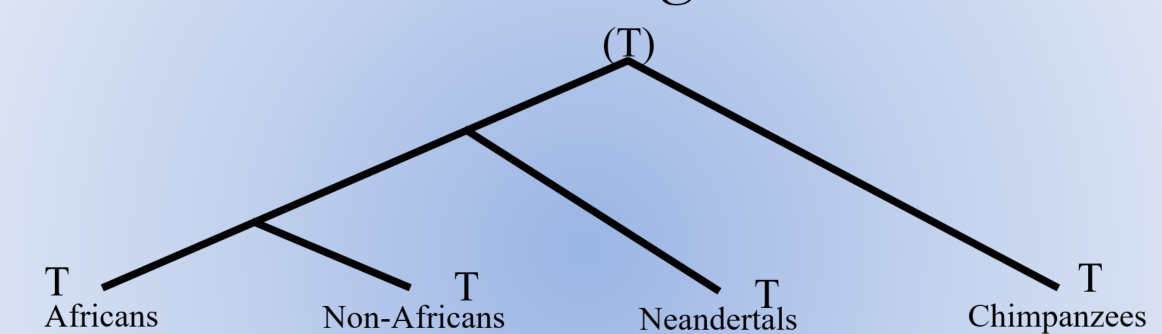

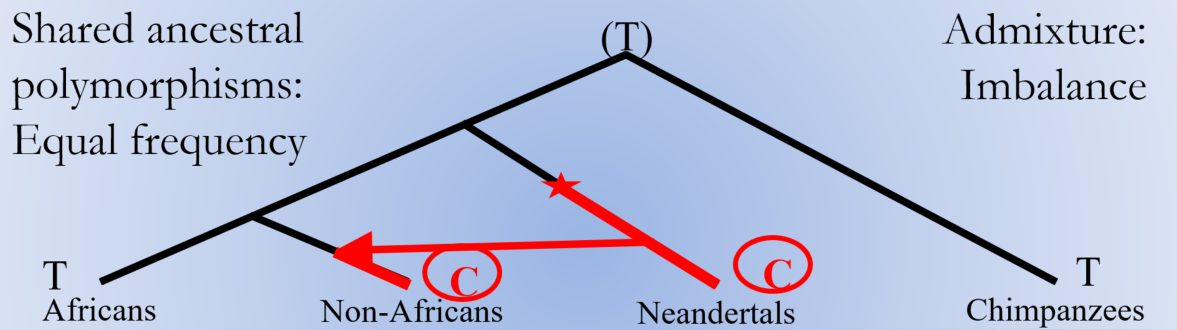

For example if modern non-Africans (X) shared more alleles with Neanderthals than Africans:

```
f4(Yoruba, X; Neanderthal, Chimpanzee)
f4 > 0      X closer to Neanderthal than Yoruba
f4 < 0      Yoruba closer to Neanderthal than to X
```



## f4 in admixtools

Now we want to focus on f4-statistics to see if there was admixture between some populations. So, we calculate f4-statistics. Here, we take a different table of precomputed f-statistics:

```
f2_blocks = f2_from_precomp("genos")
```

First, let's check the f4-stats for Neanderthal introgression:

```
f4_table1<-f4(f2_blocks,pop1="Yoruba.DG", pop2=c("Finnish.DG", "Japanese.DG","Mbuti.DG", "Papuan.DG"),pop3="Altai_Neanderthal.DG", pop4="Chimp.REF")
```

What do we see here?

```
f4_table2<-f4(f2_blocks,pop1="Yoruba.DG", pop2=c("Finnish.DG", "Japanese.DG","Mbuti.DG", "Papuan.DG"),pop3="Altai_Neanderthal.DG", pop4="Denisova.DG")
```

And now look at Denisovan ancestry only:
```
f4_table3<-f4(f2_blocks,pop1="Papuan.DG", pop2=c("Finnish.DG", "Yoruba.DG","Mbuti.DG", "Japanese.DG"),pop3="Denisova.DG", pop4="Chimp.REF")
f4_table4<-f4(f2_blocks,pop1="Japanese.DG", pop2=c("Finnish.DG", "Yoruba.DG","Mbuti.DG", "Papuan.DG"),pop3="Denisova.DG", pop4="Chimp.REF")
```


# More on f-stats

It is really a good idea to study the [documentation](https://uqrmaie1.github.io/admixtools/articles/fstats.html) an admixtools to understand what is happening!


## Limits of f4

There are limits of detection, some events cannot be found with f4-statistics.

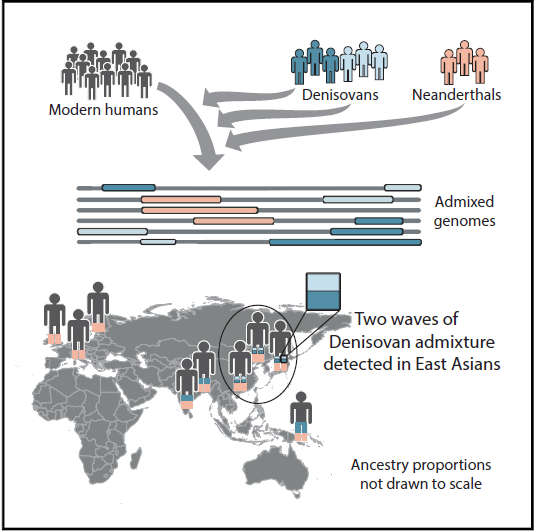

(Browning et al., 2018)

To understand the caveats and limitations of f-statistics and these tools (and become more critical of typical aDNA papers), one may study the (extensive) documentation:

https://uqrmaie1.github.io/admixtools/index.html

Screening the genome for introgressed fragments is a solution.


# Replicating results from a study

## A typical aDNA study
Hajdinjak et al. 2021:
https://doi.org/10.1038/s41586-021-03335-3

![image.png](attachment:image.png)

This is a study on ancient genomes from early modern humans in Western Eurasia, in order to put them into context of the broad history of Eurasia. As you see, it includes D/f-statistics and admixture graphs (and a lot of other things), so it is quite typical in the framework they use.

Hajdinjak and colleagues used D-statistics to investigate if some ancient/archaic individuals (X) shared more alleles with the eastern Tianyuan or western Kostenki14.

With this they wanted to see if those individuals contributed more towards modern East or West Eurasians.

```
D/f4(Tianyuan, Kostenki14; X, Mbuti) 
D(A, B; C, D) or f4(D, C; B, A)

D(Tianyuan, Kostenki14; X, Mbuti) 
D(Mbuti, X; Kostenki14, Tianyuan)

D/f4 > 0        X closer to Tianyuan than to Kostenki14
D/f4 < 0        X closer to Kostenki14 than to Tianyuan
```


## Calculate f4-stats

To do this, we need to calulate the proper statistics again for the right combination of individuals, starting from the original file:

```
extract_f2(pref="/lisc/scratch/course/2024w550001/share/dataset",
    outdir="genos2",blgsize=500000,
    overwrite=T,maxmem=1000,
    pops=c("China_Tianyuan", "Russia_Kostenki14.SG","Mbuti.DG", "Russia_Ust_Ishim.DG","Romania_Oase","Belgium_UP_GoyetQ116_1", "Russia_Sunghir3.SG","Czech_Vestonice16"))

f2_blocks = f2_from_precomp("genos2")

f4table<-f4(f2_blocks,pop1="China_Tianyuan", pop2="Russia_Kostenki14.SG", pop3=c("Russia_Ust_Ishim.DG","Romania_Oase","Belgium_UP_GoyetQ116_1","Russia_Sunghir3.SG", "Czech_Vestonice16"), pop4="Mbuti.DG")
```

Let's plot them in the easiest possible plot that ggplot (a very common plotting package in R) has to offer:

```
dat<-data.frame(pop=f4table$pop3, fs=f4table$est,se=f4table$se)

#png("f4_stats.png",600,400)
ggplot(dat, aes(y=pop, x=fs)) + geom_pointrange(aes(xmin=fs-se, xmax=fs+se))
#dev.off()
```

When you compare this to panel b of above figure from the paper, you can see that the directions of values are quite similar, but these are f4-statistics, not D-statistics.

Of course, this most basic plot doesn't look as nice as a figure in a publication...



## D-statistics, as shown in the paper

So, let's go one step further and calculate the D-statistics, since this is of course also possible in admixtools.

```
dtable<-qpdstat("/lisc/scratch/course/2024w550001/share/dataset",pop1="China_Tianyuan", pop2="Russia_Kostenki14.SG", pop3=c("Russia_Ust_Ishim.DG","Romania_Oase","Belgium_UP_GoyetQ116_1","Russia_Sunghir3.SG", "Czech_Vestonice16"), pop4="Mbuti.DG",f4mode=F)
```

Then, we can make a nice plot that has some similarity with the figure in the paper. For this, we have to define a bunch of things in ggplot:

```
dat<-data.frame(pop=dtable$pop3, fs=dtable$est,se=dtable$se,sig=ifelse(dtable$z<3&dtable$z>(-3),F,T))
dat$pop <- factor(dat$pop, levels = rev(dat$pop))

#png("d_stats.png",600,400)
ggplot(dat, aes(y=pop, x=fs)) + geom_pointrange(aes(xmin=fs-se, xmax=fs+se,shape = factor(sig)),fatten=3,size=2,fill="white") + xlim(-0.12,0.06) + scale_shape_manual(values = c(21, 19)) + theme_bw() + theme(legend.position="none", axis.text=element_text(size=16),axis.title.x = element_text(size = 18),  axis.title.y = element_text(size = 18),plot.background = element_rect(fill = "white")) + labs(title="D(Tianyuan,Kostenki;X,Mbuti)",x ="D", y = "Individual") + geom_vline(xintercept=0,linetype=3)
#dev.off()
```

As you can see, these are replicable results!